Completed iteration 0 with error <object type:float64>.
Completed iteration 25 with error <object type:float64>.
Completed iteration 50 with error <object type:float64>.
Completed iteration 75 with error <object type:float64>.
Completed iteration 100 with error <object type:float64>.
Completed iteration 125 with error <object type:float64>.
Completed iteration 150 with error <object type:float64>.
Completed iteration 175 with error <object type:float64>.
Completed iteration 200 with error <object type:float64>.
Completed iteration 225 with error <object type:float64>.
Terminated successfully in 232 interations.


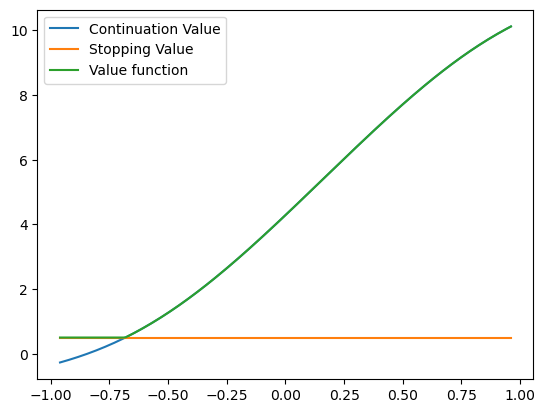

Execution time: 1.2036631107330322 seconds


In [2]:
#--------------------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------------------#
#                Dynamic Programming by John Stachurski and Tom Sargent                      #
#                                                                                            #
# This code is used for Chapter 4 OPTIMAL STOPPING: FIRM EXIT MODEL                          #
# IMPROVED USING NUMBA NJIT                                                                  #
# Written by Longye Tian 25/06/2024                                                          #
#--------------------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------------------#


#--------------------------------------------------------------------------------------------#
#                              IMPORT LIBRARIES AND PACKAGES                                 #
#--------------------------------------------------------------------------------------------#

import numpy as np
from collections import namedtuple
from scipy.stats import norm
import matplotlib.pyplot as plt
from numba import njit
import time

#--------------------------------------------------------------------------------------------#
#                          CREATE NAMEDTUPLE TO STORE MODEL PARAMETERS                       #
#--------------------------------------------------------------------------------------------#

Firm_Exit = namedtuple("firm_exit",("n",                        # Productivity grid size
                                    "m",                        # range 
                                    "ρ",                        # Persistence
                                    "μ",                        # Mean
                                    "ν",                        # Volatility
                                    "β",                        # Discount rate
                                    "s"                         # Scrap value
                                   ))

def create_firm_exit_model(n=200, m=3, ρ=0.95,μ=0.1,ν=0.1,β=0.98,s=0.5):
    return Firm_Exit(n=n,m=m,ρ=ρ,μ=μ,ν=ν,β=β,s=s)

# firm_exit = create_firm_exit_model()

#--------------------------------------------------------------------------------------------#
#                                      NORMAL CDF                                            #
#--------------------------------------------------------------------------------------------#

@njit
def norm_cdf(x, mean=0, std=1):
    # Transform x to the standard normal
    z = (x - mean) / std
    
    # Use the Abramowitz & Stegun approximation for standard normal
    t = 1 / (1 + 0.2316419 * np.abs(z))
    d = 0.3989423 * np.exp(-z * z / 2)
    p = d * t * (0.3193815 + t * (-0.3565638 + t * (1.781478 + t * (-1.821256 + t * 1.330274))))
    
    return 1 - p if z > 0 else p



#--------------------------------------------------------------------------------------------#
#                                TAUCHEN DISCRETIZATION                                      #
#--------------------------------------------------------------------------------------------#

@njit
def Tauchen(firm_exit):  
    n,m,ρ,μ,ν,β,s = firm_exit                                  # Unpack model parameters
    σ_w = np.sqrt(ν**2/(1-ρ**2))                               # W's std
    W = np.linspace(-m*σ_w, m*σ_w, n)                          # State space by Tauchen
    s = (W[n-1]-W[0])/(n-1)                                    # gap between two states
    P = np.zeros((n,n))                                        # Initialize P
    for i in range(n):
        P[i,0] = norm_cdf(W[0]-ρ*W[i]+s/2, std=σ_w)            # j=1
        P[i,n-1] = 1 - norm_cdf(W[n-1]-ρ*W[i]-s/2, std=σ_w)    # j=n
        for j in range(1,n-1):
            P[i,j] = norm_cdf(W[j]-ρ*W[i]+s/2, std=σ_w)-norm_cdf(W[j]-ρ*W[i]-s/2, std=σ_w)
    return W,P





#--------------------------------------------------------------------------------------------#
#                          BELLMAN OPERATOR FOR FIRM EXIT MODEL                              #
#--------------------------------------------------------------------------------------------#

@njit
def T(v, firm_exit):
    n,m,ρ,μ,ν,β,s = firm_exit                                 # Unpack model parameters
    Z,Q = Tauchen(firm_exit)                                  # Get Z,P
    S = s * np.ones(n)                                        # Stopping value function
    h = Z + β * (Q@v)                                         # Continuation value function
    return np.maximum(S,h)


#--------------------------------------------------------------------------------------------#
#                                   v-greedy policy                                          #
#--------------------------------------------------------------------------------------------#

@njit
def get_greedy(v, firm_exit):
    n,m,ρ,μ,ν,β,s = firm_exit                                 # Unpack model parameters
    Z,Q = Tauchen(firm_exit)                                  # Get Z,P
    S = s * np.ones(n)                                        # Stopping value function
    h = Z + β * (Q@v)                                         # Continuation value function
    σ = np.where(S>=h, 1, 0)                                  # v-greedy policy
    return σ


#--------------------------------------------------------------------------------------------#
#                                SUCCESSIVE APPROXIMATION                                    #
#--------------------------------------------------------------------------------------------#

@njit
def successive_approx (T,                                        # A callable operator
                       v_init,                                   # Initial condition
                       firm_exit,                            # Model parameter
                       tol = 1e-6,                               # Error tolerance
                       max_iter = 10_000,                        # max iterations
                       print_step = 25                           # Print at multiples of print_step
                      ):
    v = v_init                                                   # set the initial condition
    error = tol + 1                                              # Initialize the error
    k = 0                                                        # initialize the iteration
    
    while error > tol and k < max_iter: 
        new_v = T(v,firm_exit)                               # update by applying operator T
        error = np.max(np.abs(new_v-v))                          # update the error
        if k % print_step == 0:                                   
            print(f"Completed iteration {k} with error {error}.") 
        v = new_v                                                # update x
        k += 1                                                   # update the steps
    if error <= tol:                                    
        print(f"Terminated successfully in {k} interations.")
    else:     
        print("Warning: hit iteration bound.")
    return v   

#--------------------------------------------------------------------------------------------#
#                                 VALUE FUNCTION ITERATION                                   #
#--------------------------------------------------------------------------------------------#

def value_function_iteration (firm_exit):
    n,m,ρ,μ,ν,β,s = firm_exit                                 # Unpack model parameters
    v_init = np.zeros(n)                                      # initialize Value function
    v_star = successive_approx(T, v_init, firm_exit)    
    σ_star = get_greedy(v_star, firm_exit)                    # σ* is v*-greedy
    return v_star, σ_star

#--------------------------------------------------------------------------------------------#
#                   PLOT CONTINUATION, STOPPING AND VALUE FUNCTIONS                          #
#--------------------------------------------------------------------------------------------#

def plot_value_stopping_continue (firm_exit):
    n,m,ρ,μ,ν,β,s = firm_exit                                 # Unpack model parameters
    Z,Q = Tauchen(firm_exit)                                  # Get Z,P
    v_star, σ_star = value_function_iteration(firm_exit) 
    S = s * np.ones(n)                                        # Stopping value function
    h = Z + β * (Q@v_star)                                    # Continuation value function
    plt.plot(Z, h, label='Continuation Value')
    plt.plot(Z, S, label='Stopping Value')
    plt.plot(Z, v_star, label='Value function')
    plt.legend()
    plt.show()
    
    
#--------------------------------------------------------------------------------------------#
#                                         PLAYGROUND                                         #
#--------------------------------------------------------------------------------------------#

start_time = time.time()

#------------ON YOUR MARKS---------SET----------------BANG!----------------------------------#


firm_exit = create_firm_exit_model()
plot_value_stopping_continue (firm_exit)



#-------------------------------------------------------------------------------------------#
end_time = time.time()

print(f"Execution time: {end_time - start_time} seconds")